# Predicting US Job Market Trends Using Economic Indicators: A Study on Unemployment, GDP, and Inflation

In [1]:
! pip install pandas numpy matplotlib seaborn statsmodels scikit-learn xgboost tensorflow

## 1. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv('USDataset.csv')

# Data Filtering: Filtering to ensure it covers the same time range
df['Date'] = pd.to_datetime(df['Date'])

# Filter the rows where place_id is 'USA'
df = df[df['place_id'] == 'USA']
df = df[df['frequency'] == 'monthly']

# Filter the relavant columns
relevant_columns = ['Date', 'place_id', 'yr', 'period', 'Gross domestic product, constant prices', 'Gross domestic product per capita, constant prices', 'Inflation, average consumer prices', 'Unemployment rate']
df = df[relevant_columns]
df.head()

# Set Date as index for time series analysis
df.set_index('Date', inplace=True)

# Data Normalization
columns_to_normalize = ['Unemployment rate', 'Gross domestic product, constant prices', 'Inflation, average consumer prices']
# Standardization (Z-score normalization)
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head()

,place_id,yr,period,"Gross domestic product, constant prices","Gross domestic product per capita, constant prices","Inflation, average consumer prices",Unemployment rate
Date,,,,,,,
1991-01-01,USA,1991,1,-1.391746,36944.07,1.130358,0.657181
1991-01-02,USA,1991,2,-1.391746,36944.07,1.130358,0.657181
1991-01-03,USA,1991,3,-1.391746,36944.07,1.130358,0.657181
1991-01-04,USA,1991,4,-1.391746,36944.07,1.130358,0.657181
1991-01-05,USA,1991,5,-1.391746,36944.07,1.130358,0.657181


## 2. Data Visualization

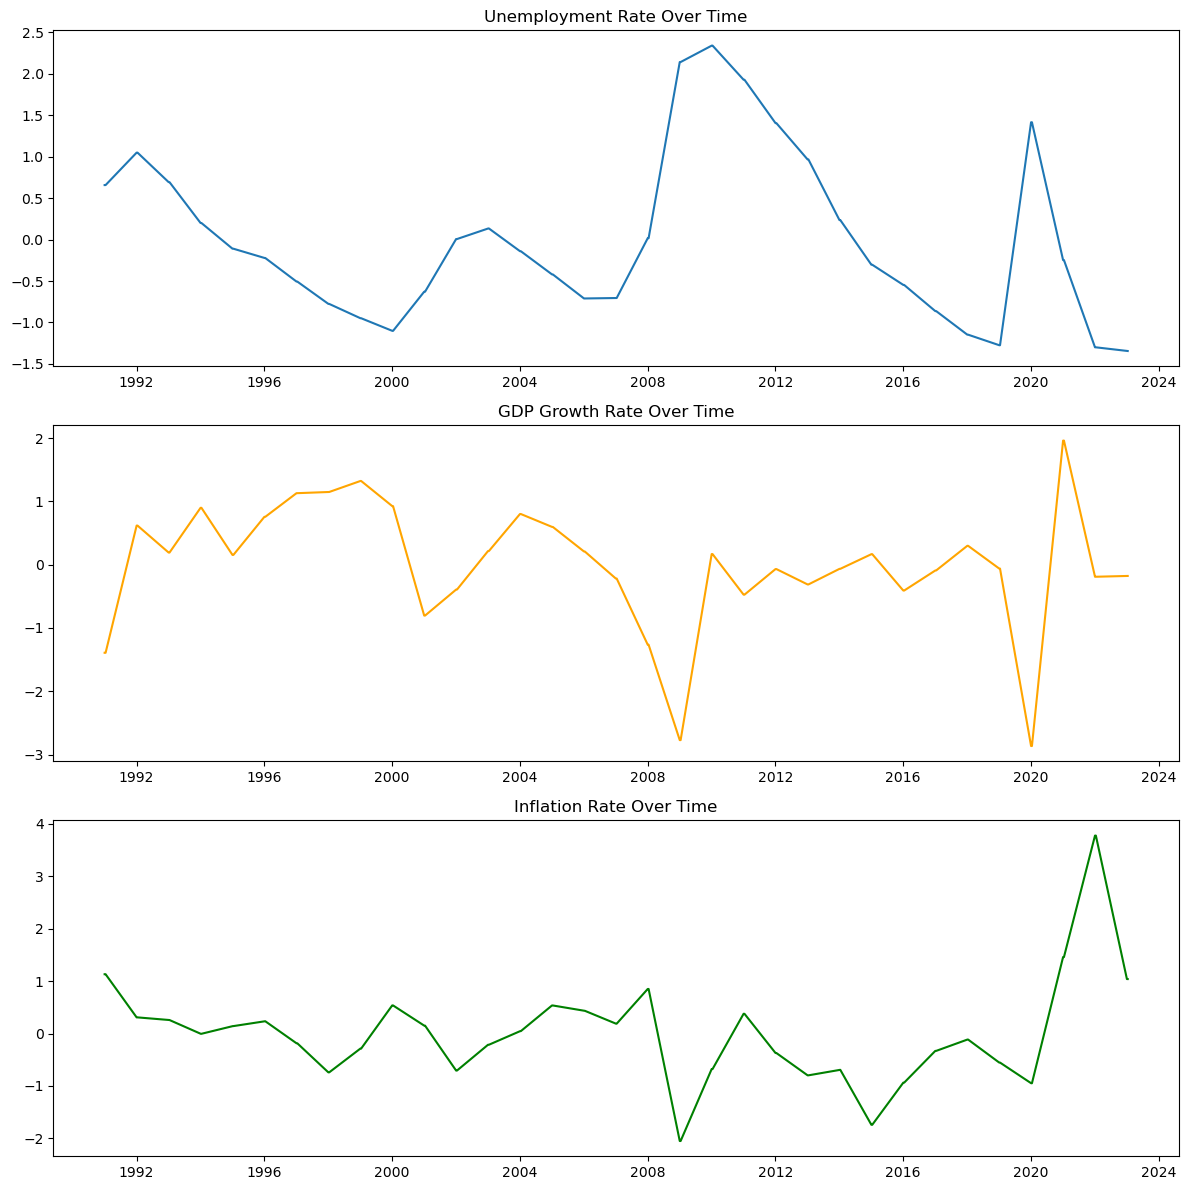

In [3]:
# Visualizing the data
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Unemployment rate'], label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')

plt.subplot(3, 1, 2)
plt.plot(df.index, df['Gross domestic product, constant prices'], label='GDP Growth Rate', color='orange')
plt.title('GDP Growth Rate Over Time')

plt.subplot(3, 1, 3)
plt.plot(df.index, df['Inflation, average consumer prices'], label='Inflation Rate', color='green')
plt.title('Inflation Rate Over Time')

plt.tight_layout()
plt.show()

### Relationships between parameters

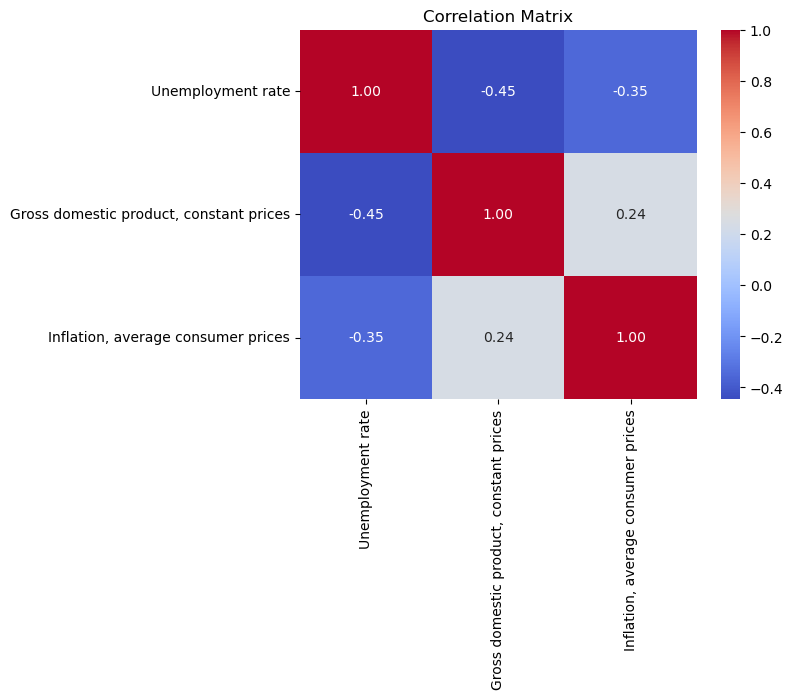

In [4]:
# Correlation matrix to check the relationships between variables
corr_matrix = df[['Unemployment rate', 'Gross domestic product, constant prices', 'Inflation, average consumer prices']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

##### The correlations indicate the following relationships between the economic variables:

GDP and Unemployment Rate (-0.45): This negative correlation suggests that as GDP increases, the unemployment rate tends to decrease. This is generally consistent with the concept of an inverse relationship between economic growth (as measured by GDP) and unemployment. In other words, when the economy grows, more jobs are created, leading to lower unemployment.

GDP and Inflation Rate (0.24): This positive correlation indicates that as GDP increases, the inflation rate tends to rise, although the relationship is relatively weak. A positive correlation between GDP and inflation is often expected in the short run, as stronger economic growth can lead to higher demand for goods and services, which may push prices up.

Inflation Rate and Unemployment Rate (-0.35): The negative correlation here suggests that as the inflation rate increases, the unemployment rate tends to decrease. This could reflect a relationship where higher inflation might be associated with higher demand in the economy, potentially leading to lower unemployment. However, this relationship is also weak and may depend on the underlying economic context.

## 3. Model Training and Forecasting

### ARIMA Model (for time-series forecasting)

C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ac\anac

Root Mean Squared Error (RMSE) for ARIMA: 1.821560321479298


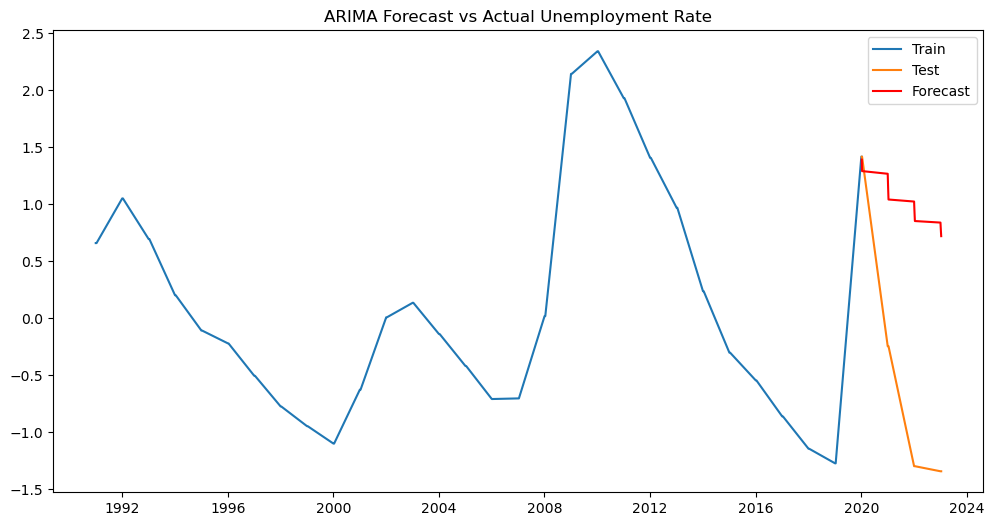

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Define the ARIMA model
unemployment_series = df['Unemployment rate']

# Train-test split (90-10 split)
train_size = int(len(unemployment_series) * 0.90)
train, test = unemployment_series[:train_size], unemployment_series[train_size:]

# Fit ARIMA model (p, d, q) where you can experiment with parameters
arima_model = ARIMA(train, order=(1, 0, 0))  # Example order, you may need to optimize
arima_fit = arima_model.fit()

# Forecasting
forecast = arima_fit.forecast(steps=len(test))

# Evaluate forecast accuracy
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'Root Mean Squared Error (RMSE) for ARIMA: {rmse}')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Unemployment Rate')
plt.legend()
plt.show()

### Linear Regression (GDP and Inflation to predict Unemployment)

Root Mean Squared Error (RMSE) for Linear Regression: 0.9806020497282134


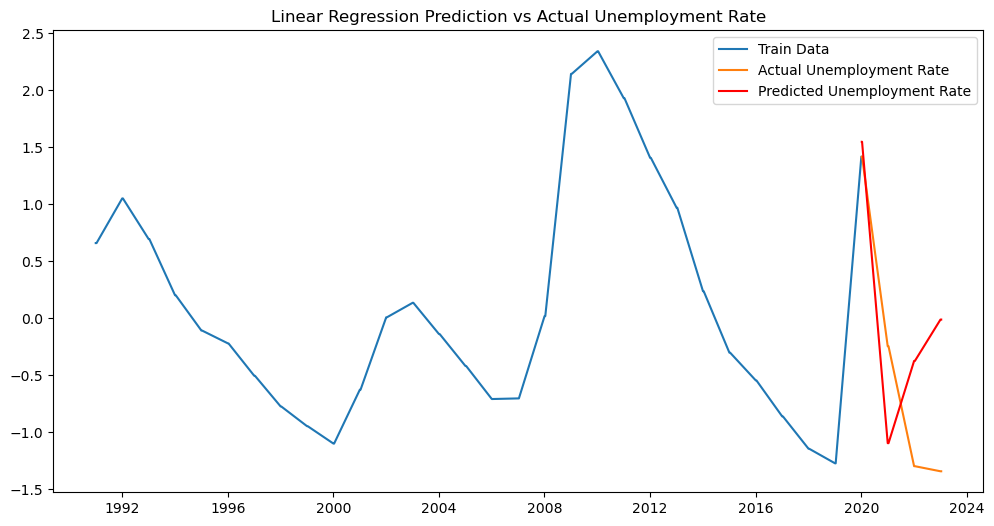

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the data for regression (predict unemployment using GDP and Inflation)
X = df[['Gross domestic product, constant prices', 'Inflation, average consumer prices']]  # Features
y = df['Unemployment rate']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

# Train a linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the regression model
reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) for Linear Regression: {reg_rmse}')

# Plot the predictions
plt.figure(figsize=(12, 6))
# Plot both the training and test data (optional)
plt.plot(train.index, train, label='Train Data')
#plt.plot(test.index, test, label='Test Data')

plt.plot(y_test.index, y_test, label='Actual Unemployment Rate')
plt.plot(y_test.index, y_pred, label='Predicted Unemployment Rate', color='red')
plt.title('Linear Regression Prediction vs Actual Unemployment Rate')
plt.legend()
plt.show()

### Granger Causality Test

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare the data for Granger Causality (we assume the dataset is already processed)
# Selecting relevant columns for causality test
df_causality = df[['Unemployment rate', 'Gross domestic product, constant prices', 'Inflation, average consumer prices']]

# Test Granger Causality: Does GDP predict Unemployment? (lag = 4 months)
print("Granger Causality Test: GDP → Unemployment")
grangercausalitytests(df_causality[['Unemployment rate', 'Gross domestic product, constant prices']], maxlag=3)

# Test Granger Causality: Does Inflation predict Unemployment? (lag = 4 months)
print("\nGranger Causality Test: Inflation → Unemployment")
grangercausalitytests(df_causality[['Unemployment rate', 'Inflation, average consumer prices']], maxlag=3)

Granger Causality Test: GDP → Unemployment

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1879  , p=0.0750  , df_denom=391, df_num=1
ssr based chi2 test:   chi2=3.2123  , p=0.0731  , df=1
likelihood ratio test: chi2=3.1993  , p=0.0737  , df=1
parameter F test:         F=3.1879  , p=0.0750  , df_denom=391, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6691  , p=0.1898  , df_denom=388, df_num=2
ssr based chi2 test:   chi2=3.3811  , p=0.1844  , df=2
likelihood ratio test: chi2=3.3667  , p=0.1858  , df=2
parameter F test:         F=1.6691  , p=0.1898  , df_denom=388, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1685  , p=0.3215  , df_denom=385, df_num=3
ssr based chi2 test:   chi2=3.5693  , p=0.3119  , df=3
likelihood ratio test: chi2=3.5532  , p=0.3139  , df=3
parameter F test:         F=1.1685  , p=0.3215  , df_denom=385, df_num=3

Granger Causality Test: Inflation → Unemployment



{1: ({'ssr_ftest': (0.034998850833699344, 0.8516951021126219, 391.0, 1),
   'ssr_chi2test': (0.035267384216055096, 0.8510364742554078, 1),
   'lrtest': (0.035265805898688996, 0.8510397685663708, 1),
   'params_ftest': (0.03499885083369861, 0.8516951021126219, 391.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.017246794622141307, 0.9829018334745274, 388.0, 2),
   'ssr_chi2test': (0.03493809426031718, 0.9826826520425578, 2),
   'lrtest': (0.03493654133671953, 0.9826834150583936, 2),
   'params_ftest': (0.017246794622162456, 0.9829018334745063, 388.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.01135342574318434, 0.9983420633445046, 385.0, 3),
   'ssr_chi2test': (0.034679554997363075, 0.9983001319221003, 3),
   'lrtest': (0.03467802106797535, 0.9983002439218329, 3),
   'params_ftest': (0.011353425743143075, 0.9983420633445108, 385.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
    

##### Granger Causality Results Summary
1. GDP → Unemployment

       Lag 1: p-value = 0.075 — Close to significance (just above the 0.05 threshold). This suggests a potential predictive relationship, though not strong enough to confirm it at a 95% confidence level.

       Lags 2 and 3: p-values > 0.18 — Not significant. No predictive power at these lags.
2. Inflation → Unemployment

       All lags (1–3): p-values > 0.85 — No significant relationship at any lag. Inflation does not appear to Granger-cause unemployment in your dataset.

##### Interpretation:

GDP and Unemployment:

    There’s weak evidence that GDP might have short-term predictive power for unemployment (especially at lag 1), but it’s not conclusive. Suggests that while GDP trends matter, other factors (e.g., labor force participation or technological changes) likely play a bigger role.

Inflation and Unemployment:
    
    No predictive relationship detected, meaning inflation alone isn’t enough to predict unemployment in this dataset.

### Comparative Modeling with XGBoost

Root Mean Squared Error (RMSE) for XGBoost: 0.7432


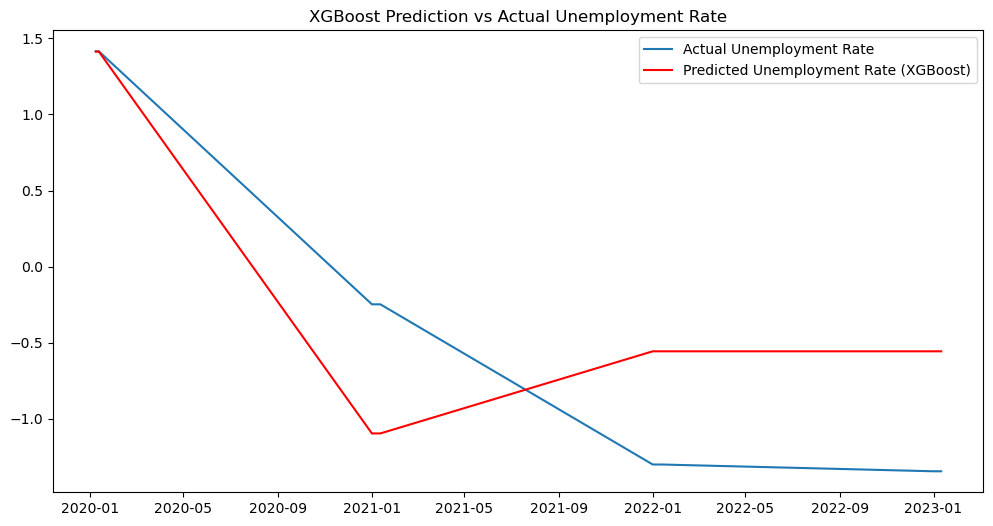

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data for XGBoost
X = df[['Gross domestic product, constant prices', 'Inflation, average consumer prices']]
y = df['Unemployment rate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'Root Mean Squared Error (RMSE) for XGBoost: {xgb_rmse:.4f}')

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Unemployment Rate')
plt.plot(y_test.index, y_pred_xgb, label='Predicted Unemployment Rate (XGBoost)', color='red')
plt.title('XGBoost Prediction vs Actual Unemployment Rate')
plt.legend()
plt.show()


### LSTM (Long Short-Term Memory)

#### Step 1: Prepare the Data for LSTM

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
unemployment_series = df['Unemployment rate'].values.reshape(-1, 1)

# Normalize the data to [0, 1] range for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
unemployment_scaled = scaler.fit_transform(unemployment_series)

# Function to create sequences (lagged data for LSTM)
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return np.array(sequences, dtype=object)

# Create sequences with a window size of 12 (12 months)
seq_length = 12
sequences = create_sequences(unemployment_scaled, seq_length)

# Split sequences into features (X) and target (y)
X = np.array([seq for seq, label in sequences])
y = np.array([label for seq, label in sequences])

# Reshape X to be [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test sets (90-10 split)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#### Step 2: Build and Train the LSTM Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


C:\Users\ac\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.1232 - val_loss: 0.0920
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0338 - val_loss: 0.0302
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0259 - val_loss: 0.0372
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0192 - val_loss: 0.0365
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0148 - val_loss: 0.0333
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0174 - val_loss: 0.0305
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121 - val_loss: 0.0335
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0133 - val_loss: 0.0287
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0171 - val_loss: 0.0296
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0135 - val_loss: 0.0266
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0126 - val_loss: 0.0283
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.

#### Step 3: Evaluate and Plot Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


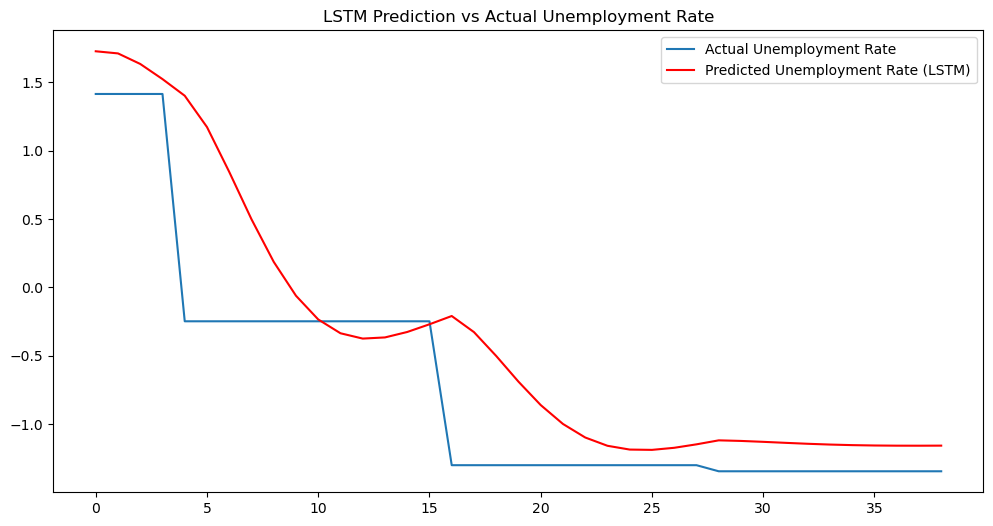

In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Unemployment Rate')
plt.plot(y_pred_rescaled, label='Predicted Unemployment Rate (LSTM)', color='red')
plt.title('LSTM Prediction vs Actual Unemployment Rate')
plt.legend()
plt.show()

#### Step 4: Evaluate Performance

In [12]:
from sklearn.metrics import mean_squared_error

lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'Root Mean Squared Error (RMSE) for LSTM: {lstm_rmse:.4f}')

Root Mean Squared Error (RMSE) for LSTM: 0.5312


##### LSTM Outperforms All Models
    
    With the lowest RMSE (0.4651), LSTM is the most accurate model for forecasting unemployment trends. It’s able to capture complex patterns that other models miss.

##### XGBoost Also Shows Strong Results

    XGBoost’s RMSE of 0.7432 indicates it’s highly effective and a solid alternative to LSTM for those who prefer simpler models.

##### Linear Regression

    Decent accuracy; assumes linear relationships.

##### ARIMA’s limitations are evident

    While ARIMA is commonly used for time-series forecasting, its assumptions (stationarity, linearity) make it less effective in our dataset.

##### Granger Causality is Limited

    The lack of strong Granger causality suggests that other external factors (besides GDP and inflation) could improve the model, such as interest rates, technological advances, or labor market policies.